In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
train_dir = 'dataset\\train'
test_dir = 'dataset\\test'

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,                  
    rotation_range=20,               
    width_shift_range=0.2,          
    height_shift_range=0.2,          
    shear_range=0.2,               
    zoom_range=0.2,                
    horizontal_flip=True,           
)

In [4]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 85 images belonging to 2 classes.


In [6]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 22 images belonging to 2 classes.


In [7]:
train_generator.class_indices

{'mature': 0, 'unmatured': 1}

In [8]:
class SpatialAttention(layers.Layer):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.kernel_size = kernel_size

    def build(self, input_shape):

        self.conv = layers.Conv2D(1, self.kernel_size, strides=1, padding='same', use_bias=False)
        
    def call(self, inputs):

        avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)

        concat = tf.concat([avg_pool, max_pool], axis=-1)

        attention = self.conv(concat)

        attention = layers.Activation('sigmoid')(attention)

        output = layers.Multiply()([inputs, attention])
        
        return output


In [9]:
input_shape=(224, 224, 3)

In [11]:
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

In [15]:
model = models.Sequential([
    base_model,
    SpatialAttention(),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='sigmoid') 
])

In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_attention               │ (None, 7, 7, 512)      │            98 │
│ (SpatialAttention)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 7, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,244,196 (58.15 MB)

 Trainable params: 528,484 (2.02 MB)

 Non-trainable params: 14,715,712 (56.14 MB)

In [18]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [19]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)

class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

In [20]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1,restore_best_weights=True)

In [21]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    class_weight=class_weight_dict,
    callbacks=[early_stopping]
)

e:\MR.Mind_Projects\RP025-01\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 23s 10s/step - accuracy: 0.5002 - loss: 0.6821 - val_accuracy: 0.9091 - val_loss: 0.6601
Epoch 2/20
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 983ms/step - accuracy: 0.7500 - loss: 0.5746

e:\MR.Mind_Projects\RP025-01\venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step - accuracy: 0.7500 - loss: 0.5746 - val_accuracy: 0.9091 - val_loss: 0.6419
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 7s/step - accuracy: 0.8802 - loss: 0.4176 - val_accuracy: 0.9545 - val_loss: 0.5925
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step - accuracy: 0.9688 - loss: 0.2862 - val_accuracy: 0.9545 - val_loss: 0.5634
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 6s/step - accuracy: 0.8438 - loss: 0.3098 - val_accuracy: 0.9545 - val_loss: 0.5006
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.9048 - loss: 0.3563 - val_accuracy: 0.9545 - val_loss: 0.4684
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.8958 - loss: 0.2459 - val_accuracy: 0.9545 - val_loss: 0.4070
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.8571 - loss: 0.3627 - val_accuracy: 0.9545 - val_loss: 0.3830
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 7s/step - accuracy: 0.9590 - loss: 0.1688 - val_accuracy: 0.9545 - val_loss: 0.3363
Epoch 10/20
2/2 ━━━━━━━

In [22]:
loss, acc = model.evaluate(test_generator)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.2122


In [24]:
import matplotlib.pyplot as plt

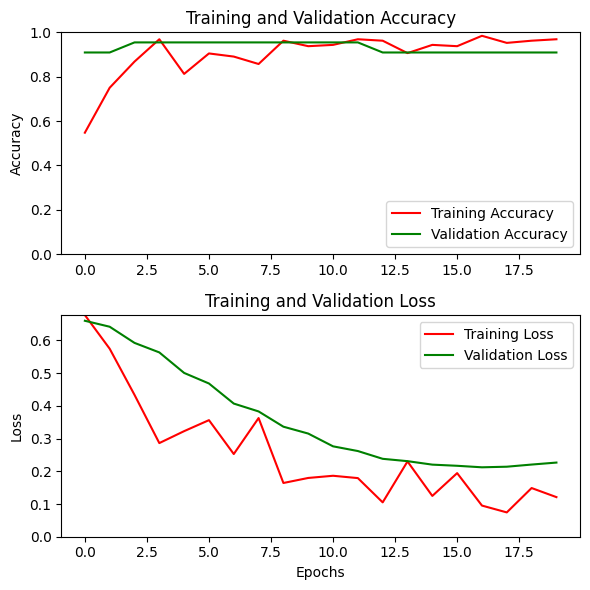

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(6, 6))

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', color='red')
plt.plot(val_acc, label='Validation Accuracy', color='green')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0, 1])  
plt.title('Training and Validation Accuracy')


plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', color='red')
plt.plot(val_loss, label='Validation Loss', color='green')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0, max(max(loss), max(val_loss))])  
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')


plt.tight_layout()  
plt.show()


In [26]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [29]:
class_indices = test_generator.class_indices
print(class_indices)

{'mature': 0, 'unmatured': 1}


In [31]:
preds = model.predict(test_generator)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


In [32]:
predicted_classes = np.argmax(preds, axis=-1)
predicted_classes

array([0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0],
      dtype=int64)

In [48]:
predictions = []
true_labels = []


In [49]:
for images, labels in test_generator:
    preds = model.predict(images)

    predicted_classes = np.argmax(preds, axis=-1)
    
    true_labels.extend(np.argmax(labels, axis=-1)) 
    predictions.extend(predicted_classes)
    
    break 


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [50]:
true_labels = np.array(true_labels)
predictions = np.array(predictions)

In [51]:
print("Classification Report:")
print(classification_report(true_labels, predictions, target_names=list(class_indices.keys())))

Classification Report:
              precision    recall  f1-score   support

      mature       0.86      1.00      0.92        12
   unmatured       1.00      0.80      0.89        10

    accuracy                           0.91        22
   macro avg       0.93      0.90      0.91        22
weighted avg       0.92      0.91      0.91        22



In [52]:
print("Confusion Matrix:")
print(confusion_matrix(true_labels, predictions))

Confusion Matrix:
[[12  0]
 [ 2  8]]


In [54]:
class_names = list(class_indices.keys())

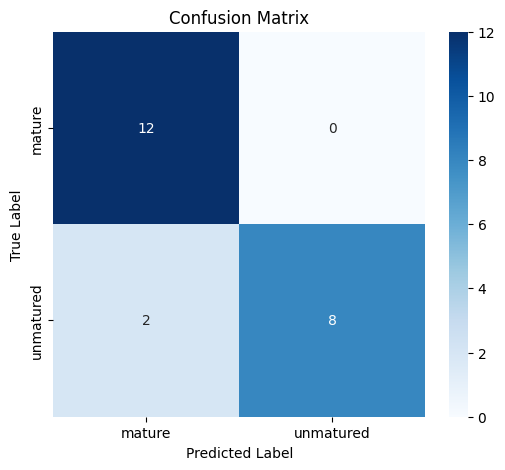

In [55]:
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(true_labels, predictions), annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Add labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [57]:
# model.save('model.h5')